<a href="https://colab.research.google.com/github/zimin205/BDA_Data/blob/main/10%EA%B8%B0%ED%95%99%ED%9A%8C%EC%9B%90%EB%B6%84%EC%84%9D_%EA%B9%80%EC%A7%80%EB%AF%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from google.colab import auth
from google.auth import default
from gspread_dataframe import set_with_dataframe
from oauth2client.service_account import ServiceAccountCredentials
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns
def sheetread(id : str):
  spreadsheet_id = id
  spreadsheet = gc.open_by_key(spreadsheet_id)

  worksheet = spreadsheet.get_worksheet(0)
  data = worksheet.get_all_records()
  df = pd.DataFrame(data)
  df.replace('', np.nan, inplace=True)

  if 'phone_number' in df.columns:
        df['phone_number'] = df['phone_number'].astype(str)

  return df

In [ ]:
df = sheetread('1LtVARnQqlseTFp48zUfMEOcks2iAkg2TKqywWLkrk1o')

<ipython-input-2-32d7afe790b6>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('', np.nan, inplace=True)


In [ ]:
print(df.columns)


Index(['타임스탬프', '개인정보 수집 및 이용', '1-1) 해당하는 항목에 체크해주세요.', '1-2) 성별을 선택하여주세요.',
       '1-3) 생년월일을 8자리로 적어주세요. ( 예시 : 20030102 )', '1-4) 현재 거주 지역을 선택해주세요.',
       '1-5) 거주지 세부 지역을 적어주세요. (예: '서울시' 선택 시 '노원구', '경기도' 선택시 '수원시' )',
       '1-6) 현재 직업을 선택해주세요', '1-7) 성함을 적어주세요.',
       '1-8) 전화번호를 11자리로 적어주세요. ( 예시 : 01012345678 ) ',
       ...
       '12-3-2) BDA WAVE 세부 프로그램인 오프라인 학술제에 참여하실 의사가 있는지 응답해주세요. \n(학술제는 정규 학회원 대상 최종 과제 중 우수 과제 발표와 우수학회원 발표가 진행됩니다.)',
       '12-3-3) 학술제에서 진행되었으면 하는 컨텐츠를 서술해주세요. ',
       '13-1) 데이터 분석 제외 교육 받고 싶은 직무를 선택해 주세요. ',
       '13-2) 어떤 레벨의 현직자에게 강연을 듣고 싶으신가요?',
       '13-3) 현직자에게 듣고 싶은 강의 주제를 아래에서 선택해 주세요.',
       '13-4) 어떤 기업의 현직자에게 강연을 듣고 싶으신가요?', '13-5) 어떤 방식의 현직자 강연을 원하시나요?',
       '13-6) 원하시는 현직자 강의의 규모를 선택해 주세요.',
       '13-7) 해당 규모를 선택하신 이유를 설명해 주세요.\n(예시: 인원이 적어야 집중할 수 있어서)', '이메일 주소'],
      dtype='object', length=128)


In [ ]:
import pandas as pd

# 컬럼명 설정 (공백 주의)
name_col = '1-7) 성함을 적어주세요.'
phone_col = '1-8) 전화번호를 11자리로 적어주세요. ( 예시 : 01012345678 )'

# 데이터 정리: 공백 제거 및 전화번호를 문자열(str)로 변환
df[name_col] = df[name_col].astype(str).str.strip()
df[phone_col] = df[phone_col].astype(str).str.strip()

# 첫 번째 행(질문 행)을 제외한 데이터프레임 생성
df_without_first = df.iloc[1:]

# 중복 제거
df_unique = df_without_first.drop_duplicates(subset=[name_col, phone_col], keep='first')

# 중복 제거 후 응답자 수 출력
print(f"중복 제거 후 총 응답자 수: {len(df_unique)}명")


중복 제거 후 총 응답자 수: 1038명


In [ ]:
# 공백 및 줄바꿈 제거
df.columns = df.columns.str.strip()  # 앞뒤 공백 제거
df.columns = df.columns.str.replace("\n", " ", regex=True)  # 줄바꿈 제거
print(df.columns.tolist())  # 수정된 컬럼명 확인

!pip install fuzzywuzzy
!pip install python-Levenshtein  # 성능 향상을 위해 추가 설치

from fuzzywuzzy import process

# 기존 선택 컬럼 리스트
selected_columns = [
    "4-1) BDA를 어떻게 알게 되셨나요?",
    "official.bdaa 계정에서 가장 관심을 끌었던 인스타그램 콘텐츠는 무엇인가요?",
    "4-5) BDA에서 가장 만족했던 활동을 선택해주세요.",
    "4-6) 10기 학회원으로써 가장 기대하는 활동을 선택해주세요.",
    "12-1-1)  10기 학회원들을 대상으로 BDA JOB를 통해 학회원분들께 취업 집중 서비스를 제공하고자 합니다. 가장 관심있는 채용 프로그램을 선택해주세요.",
    "12-1-2) 이외에 받고 싶은 취업 및 채용 서비스가 있다면 적어주세요.",
    "12-2-1) 원데이 클래스에서 다뤘으면 하는 주제를 모두 선택해주세요.",
    "12-2-2) 선호하는 원데이 클래스 강의 형식을 선택해주세요.",
    "12-2-3) 희망하는 원데이 클래스 난이도를 선택해주세요.",
    "12-2-4) 원데이 클래스에 실제 참여할 의향이 얼마나 있으신가요?",
    "12-3-1) 오프라인 행사에서 추가로 진행되었으면 하는 컨텐츠가 있다면 응답해주세요.",
    "12-3-2) BDA WAVE 세부 프로그램인 오프라인 학술제에 참여하실 의사가 있는지 응답해주세요.",
    "12-3-3) 학술제에서 진행되었으면 하는 컨텐츠를 서술해주세요."
]

# 가장 유사한 컬럼 찾기
for col in selected_columns:
    match, score = process.extractOne(col, df.columns)
    print(f"'{col}' -> '{match}' (유사도: {score}%)")


['타임스탬프', '개인정보 수집 및 이용', '1-1) 해당하는 항목에 체크해주세요.', '1-2) 성별을 선택하여주세요.', '1-3) 생년월일을 8자리로 적어주세요. ( 예시 : 20030102 )', '1-4) 현재 거주 지역을 선택해주세요.', "1-5) 거주지 세부 지역을 적어주세요. (예: '서울시' 선택 시 '노원구', '경기도' 선택시 '수원시' )", '1-6) 현재 직업을 선택해주세요', '1-7) 성함을 적어주세요.', '1-8) 전화번호를 11자리로 적어주세요. ( 예시 : 01012345678 )', '1-9) 이메일을 적어주세요.', '2-1) 귀하의 최종 학력은 어떻게 되시나요? (재학 및 휴학 포함)', '2-2-1) 현재 재학 중이신가요?', "2-2-2)  석사 과정을 진행한 대학명을 적어주세요.  (  예시 :  OO대학교 OO캠퍼스 ) * '대학교'를 포함한 풀네임으로 작성해주세요. ** 분캠의 경우 캠퍼스 명을 함께 작성해주세요.", '2-2-3) 석사 과정을 수료하고 있는 단과 대학 구분을 선택해주세요. ( 복수선택 가능, 최대 3개 )', "2-2-4) 본인의 주전공명을 적어주세요. ( 예시 :  OO학과 또는 OO학부 ) * '학과' 또는 '학부'를 포함한 풀네임으로 작성해주세요.", '2-3-1) 현재 재학 중이신가요?', '2-3-2) 휴학생의 경우 휴학한 이유를 작성해주세요.', '2-3-3) 현재 재학 중인 학기의 숫자를 적어주세요.', '2-3-4) 현재 재학 중인 학기의 수강 학점을 적어주세요.', "2-3-5)  학사 과정을 진행한 대학명을 적어주세요.  (  예시 :  OO대학교 OO캠퍼스 ) * '대학교'를 포함한 풀네임으로 작성해주세요. ** 분캠의 경우 캠퍼스 명을 함께 작성해주세요.", '2-3-6) 본인의 전공 단과 대학 구분을 선택해주세요. ( 복수선택 가능, 최대 3개 )', "2-3-7) 본인의 주전공명을 적어주세요. ( 예시 :  OO학과 또는 OO학부 ) * '학과' 또는 '학부'를 

In [ ]:
selected_columns_updated = [
    "4-1) BDA를 어떻게 알게 되셨나요?",
    "official.bdaa 계정에서 가장 관심을 끌었던 인스타그램 콘텐츠는 무엇인가요?",
    "4-5) BDA에서 가장 만족했던 활동을 선택해주세요.",
    "4-6) 10기 학회원으로써 가장 기대하는 활동을 선택해주세요.",
    "12-1-1)  10기 학회원들을 대상으로 BDA JOB를 통해 학회원분들께 취업 집중 서비스를 제공하고자 합니다. 가장 관심있는 채용 프로그램을 선택해주세요.",
    "12-1-2) 이외에 받고 싶은 취업 및 채용 서비스가 있다면 적어주세요.  예시) 중견기업 취업 특강, 해외 취업 지원, 효율적인 이직 방법 등",
    "12-2-1) 저희 학회는 학회원의 성장을 위해 현직에 종사하시는 분들을 초대하여 데이터 분석과 관련 있는 강연을 하는 원데이 클래스라는 프로그램을 진행합니다. 원데이 클래스에서 다뤘으면 하는 주제를 모두 선택해주세요.",
    "12-2-2) 선호하는 원데이 클래스 강의 형식을 선택해주세요.",
    "12-2-3) 희망하는 원데이 클래스 난이도를 선택해주세요.",
    "12-2-4) 원데이 클래스에 실제 참여할 의향이 얼마나 있으신가요?",
    "12-3-1) BDA는 BDA WAVE라는 프로그램을 통해 다음의 행사를 진행하고 있습니다.  -  현직자와의 만남(네트워킹 & 커피챗) -  현직자 강연  -  채용 공모전 시상 시 발표 기회 부여 및 현직자의 결과물 멘토링 -  학술제  오프라인 행사에서 추가로 진행되었으면 하는 컨텐츠가 있다면 응답해주세요.",
    "12-3-2) BDA WAVE 세부 프로그램인 오프라인 학술제에 참여하실 의사가 있는지 응답해주세요.  (학술제는 정규 학회원 대상 최종 과제 중 우수 과제 발표와 우수학회원 발표가 진행됩니다.)",
    "12-3-3) 학술제에서 진행되었으면 하는 컨텐츠를 서술해주세요."
]


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 30 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (11.7 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 124947 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts/truetype/nanum/Na

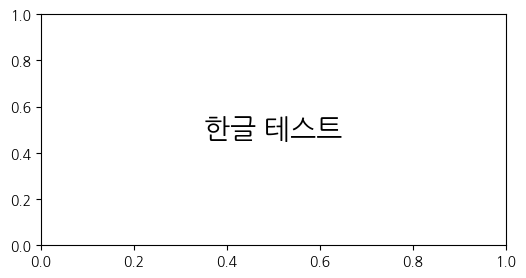

In [ ]:
# %% [code]
# 1️⃣ NanumGothic 폰트 설치
!apt-get update -qq
!apt-get install -y fonts-nanum

# 2️⃣ Matplotlib에서 폰트 캐시를 갱신
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 한글 폰트 경로 확인 (설치된 폰트 목록 확인)
!fc-list :lang=ko | grep Nanum

# 3️⃣ Matplotlib에서 사용할 폰트 경로 지정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

# 4️⃣ 폰트 적용
fm.fontManager.addfont(font_path)  # 폰트 매니저에 추가
plt.rc("font", family="NanumGothic")  # 기본 폰트 설정

# 5️⃣ Matplotlib 폰트 캐시 삭제 후 강제 갱신
!rm -rf ~/.cache/matplotlib
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 6️⃣ 폰트 적용 테스트 (한글 출력 확인)
plt.figure(figsize=(6,3))
plt.text(0.5, 0.5, "한글 테스트", fontsize=20, ha='center', va='center')
plt.show()


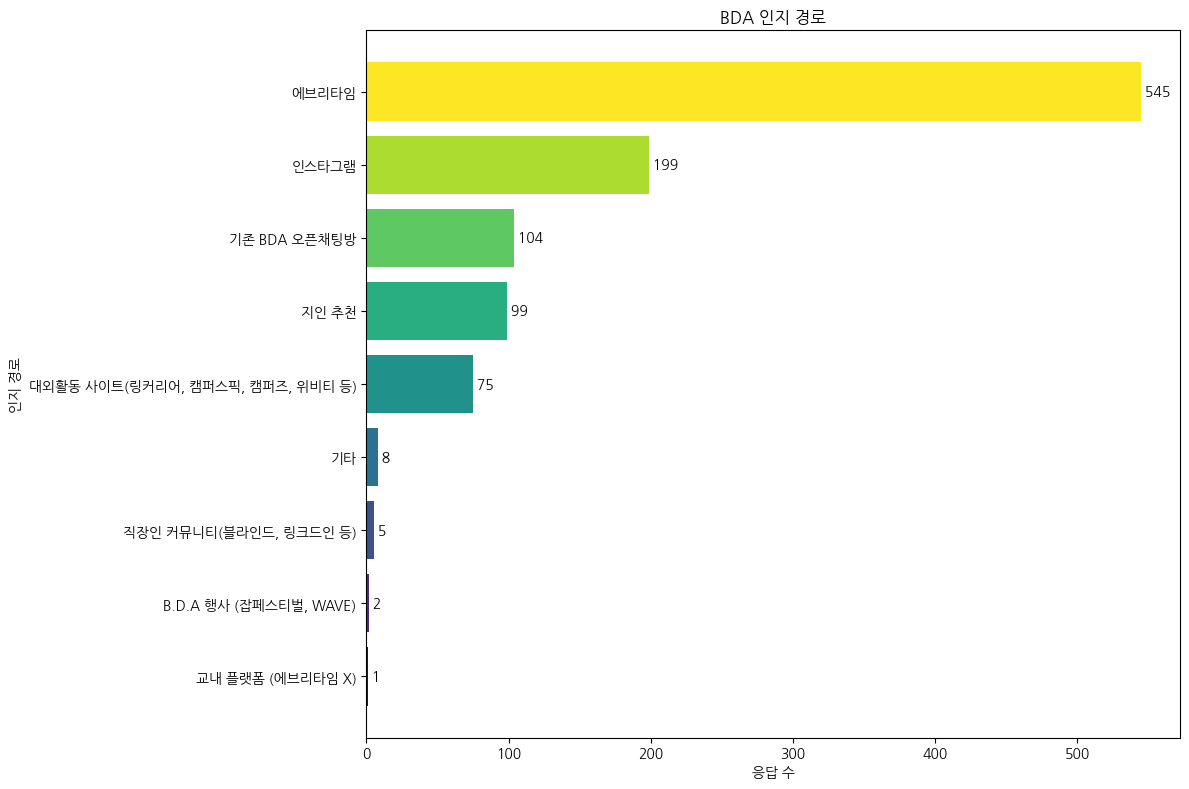

총 응답 수: 1038
총 응답자 수: 1038


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 컬럼명 설정
column = "4-1) BDA를 어떻게 알게 되셨나요?"

# 데이터 처리 (첫 번째 행은 이미 제거되었으므로 추가 제거 불필요)
responses = df_unique[column].dropna()

# 객관식 문항 리스트
predefined_options = [
    '에브리타임', '인스타그램', '교내 플랫폼 (에브리타임 X)',
    '기존 BDA 오픈채팅방', '지인 추천',
    '대외활동 사이트(링커리어, 캠퍼스픽, 캠퍼즈, 위비티 등)',
    'B.D.A 행사 (잡페스티벌, WAVE)',
    '직장인 커뮤니티(블라인드, 링크드인 등)'
]

# 응답 처리 (기타 응답 처리)
responses = responses.apply(lambda x: x if x in predefined_options else '기타')
response_counts = responses.value_counts()

# 데이터 정렬
response_counts_sorted = response_counts.sort_values(ascending=True)

# 그래프 생성
plt.figure(figsize=(12, 8))
bars = plt.barh(response_counts_sorted.index, response_counts_sorted.values)

# viridis 컬러맵 적용
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=len(bars)-1))
for i, bar in enumerate(bars):
    bar.set_facecolor(sm.to_rgba(i))

plt.title("BDA 인지 경로")
plt.xlabel("응답 수")
plt.ylabel("인지 경로")

# 각 막대에 값 표시
for i, v in enumerate(response_counts_sorted.values):
    plt.text(v, i, f' {v}', va='center')

plt.tight_layout()
plt.show()

# 총 응답 수 출력
print(f"총 응답 수: {response_counts_sorted.sum()}")
print(f"총 응답자 수: {len(responses)}")


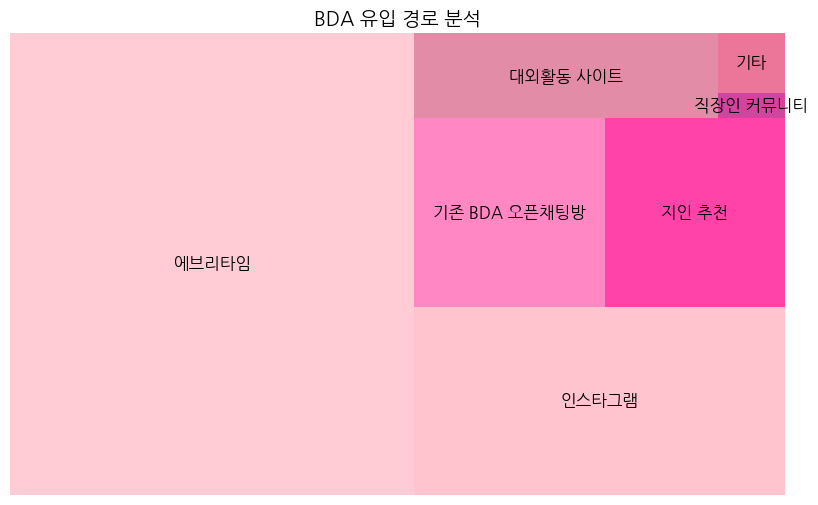

In [ ]:
!pip install squarify
import pandas as pd
import matplotlib.pyplot as plt
import squarify

# 분석할 컬럼
col_entry_path = "4-1) BDA를 어떻게 알게 되셨나요?"

# 데이터 준비
df_entry = df[col_entry_path].dropna()
entry_counts = df_entry.value_counts()

# 데이터 정리 (상위 6개 항목만 표시, 나머지는 '기타'로 합치기)
top_n = 6
if len(entry_counts) > top_n:
    other_sum = entry_counts[top_n:].sum()
    entry_counts = pd.concat([entry_counts[:top_n], pd.Series({'기타': other_sum})])  # append() 대신 concat() 사용

# 특정 응답의 긴 라벨을 짧게 변경
label_map = {
    "대외활동 사이트(링커리어, 캠퍼스픽, 캠퍼즈, 위비티 등)": "대외활동 사이트",
    "직장인 커뮤니티(블라인드, 링크드인 등)": "직장인 커뮤니티"
}
entry_counts.index = entry_counts.index.map(lambda label: label_map.get(label, label))  # 긴 라벨을 짧게 변환

# 색상 설정 (핑크 계열)
colors = ["#FFC0CB", "#FFB6C1", "#FF69B4", "#FF1493", "#DB7093", "#C71585", "#E75480"]

# 트리맵 시각화
plt.figure(figsize=(10, 6))
squarify.plot(sizes=entry_counts.values, label=entry_counts.index, alpha=0.8, color=colors, text_kwargs={'fontsize': 12})
plt.axis("off")
plt.title("BDA 유입 경로 분석", fontsize=14, fontweight='bold')

# 그래프 저장
plt.savefig("bda_entry_path_treemap.png", dpi=300)
plt.show()


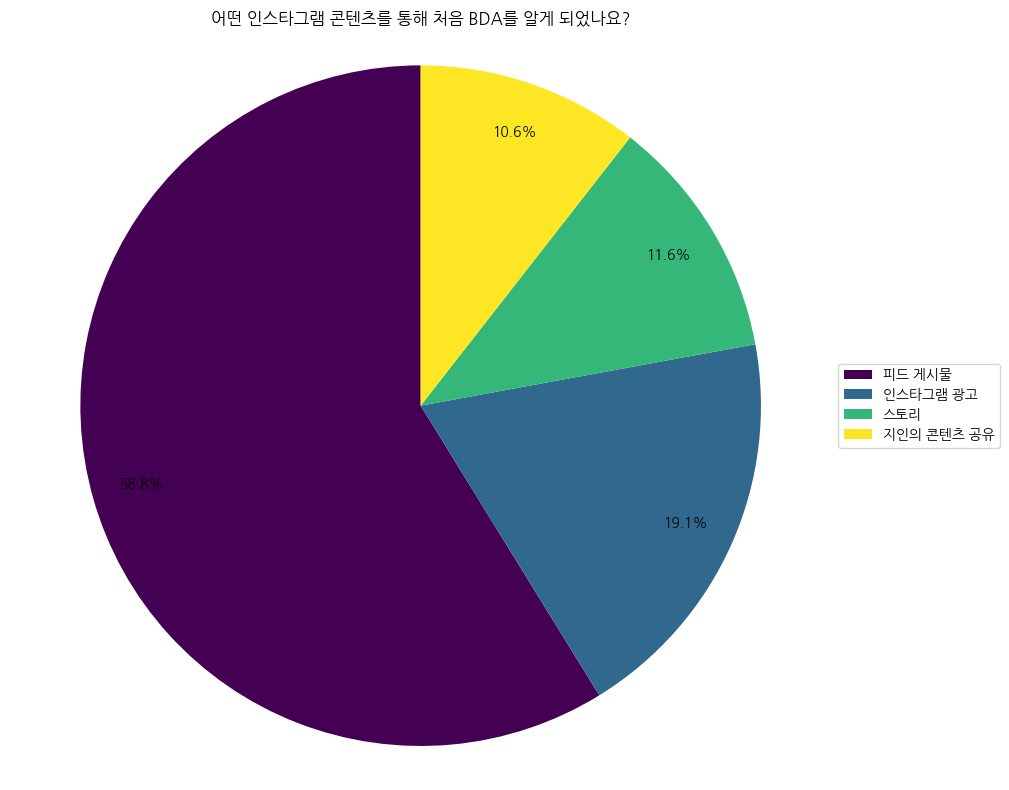

응답 별 수와 비율:
피드 게시물: 117명 (58.8%)
인스타그램 광고: 38명 (19.1%)
스토리: 23명 (11.6%)
지인의 콘텐츠 공유: 21명 (10.6%)

총 응답자 수: 199명


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm

# 컬럼명 설정
column = "어떤 인스타그램 콘텐츠를 통해 처음 BDA를 알게 되었나요?"

# 데이터 처리
responses = df_unique[column].dropna()
response_counts = responses.value_counts()

# viridis 컬러맵 설정
cmap = cm.viridis
colors = cmap(np.linspace(0, 1, len(response_counts)))

# 파이 그래프 생성
plt.figure(figsize=(12, 8))
plt.pie(response_counts.values, autopct='%1.1f%%', startangle=90, colors=colors,
        pctdistance=0.85)

plt.title("어떤 인스타그램 콘텐츠를 통해 처음 BDA를 알게 되었나요?")
plt.axis('equal')  # 원형 유지

# 범례 추가
plt.legend(response_counts.index, loc="center left", bbox_to_anchor=(1, 0.5))

# 레이아웃 조정
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 범례 공간 확보
plt.show()

# 응답 수와 비율 출력
print("응답 별 수와 비율:")
for response, count in response_counts.items():
    percentage = count / len(responses) * 100
    print(f"{response}: {count}명 ({percentage:.1f}%)")

print(f"\n총 응답자 수: {len(responses)}명")



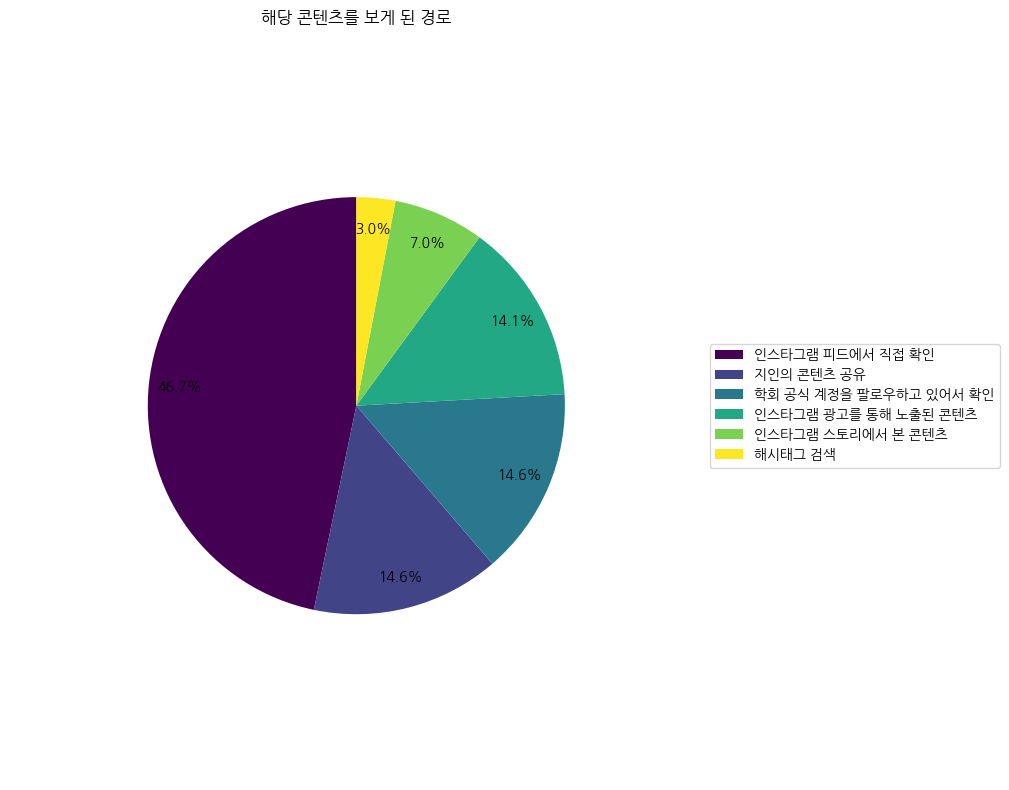

응답 별 수와 비율:
인스타그램 피드에서 직접 확인: 93명 (46.7%)
지인의 콘텐츠 공유: 29명 (14.6%)
학회 공식 계정을 팔로우하고 있어서 확인: 29명 (14.6%)
인스타그램 광고를 통해 노출된 콘텐츠: 28명 (14.1%)
인스타그램 스토리에서 본 콘텐츠: 14명 (7.0%)
해시태그 검색: 6명 (3.0%)

총 응답자 수: 199명


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm

# 컬럼명 설정
column = "해당 콘텐츠를 보게 된 경로는 무엇이었나요?"

# 데이터 처리
responses = df_unique[column].dropna()
response_counts = responses.value_counts()

# viridis 컬러맵 설정
cmap = cm.viridis
colors = cmap(np.linspace(0, 1, len(response_counts)))

# 파이 그래프 생성
plt.figure(figsize=(12, 8))
plt.pie(response_counts.values, autopct='%1.1f%%', startangle=90, colors=colors,
        pctdistance=0.85)

plt.title("해당 콘텐츠를 보게 된 경로")
plt.axis('equal')  # 원형 유지

# 범례 추가
plt.legend(response_counts.index, loc="center left", bbox_to_anchor=(1, 0.5))

# 레이아웃 조정
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 범례 공간 확보
plt.show()

# 응답 수와 비율 출력
print("응답 별 수와 비율:")
for response, count in response_counts.items():
    percentage = count / len(responses) * 100
    print(f"{response}: {count}명 ({percentage:.1f}%)")

print(f"\n총 응답자 수: {len(responses)}명")



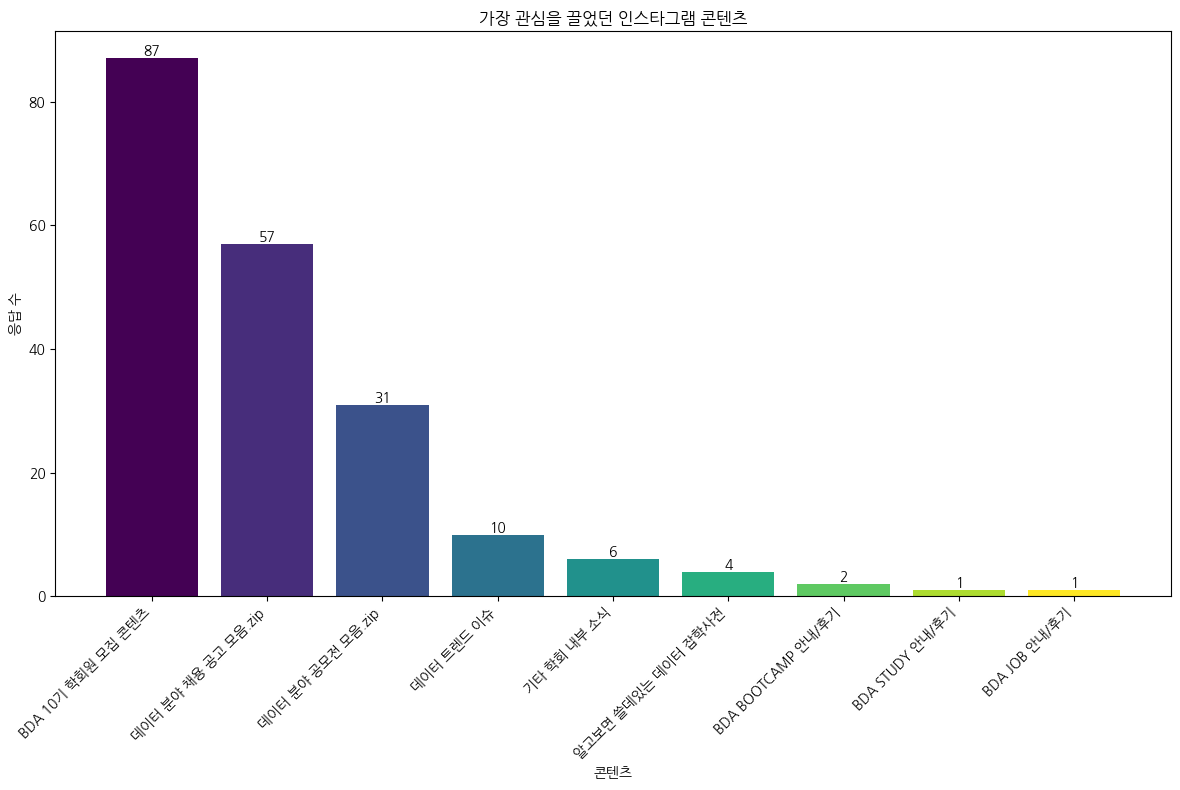

응답 별 수와 비율:
BDA 10기 학회원 모집 콘텐츠: 87명 (43.7%)
데이터 분야 채용 공고 모음.zip: 57명 (28.6%)
데이터 분야 공모전 모음.zip: 31명 (15.6%)
데이터 트렌드 이슈: 10명 (5.0%)
기타 학회 내부 소식: 6명 (3.0%)
알고보면 쓸데있는 데이터 잡학사전: 4명 (2.0%)
BDA BOOTCAMP 안내/후기: 2명 (1.0%)
BDA STUDY 안내/후기: 1명 (0.5%)
BDA JOB 안내/후기: 1명 (0.5%)

총 응답자 수: 199명


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm

# 컬럼명 설정
column = "official.bdaa 계정에서 가장 관심을 끌었던 인스타그램 콘텐츠는 무엇인가요?"

# 데이터 처리
responses = df_unique[column].dropna()
response_counts = responses.value_counts()

# viridis 컬러맵 설정
cmap = cm.viridis
colors = cmap(np.linspace(0, 1, len(response_counts)))

# 수직 막대 그래프 생성
plt.figure(figsize=(12, 8))
bars = plt.bar(response_counts.index, response_counts.values, color=colors)
plt.xticks(rotation=45, ha='right')  # x축 레이블 회전
plt.title("가장 관심을 끌었던 인스타그램 콘텐츠")
plt.xlabel("콘텐츠")
plt.ylabel("응답 수")

# 각 막대 위에 값 표기
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 응답 수와 비율 출력
print("응답 별 수와 비율:")
for response, count in response_counts.items():
    percentage = count / len(responses) * 100
    print(f"{response}: {count}명 ({percentage:.1f}%)")

print(f"\n총 응답자 수: {len(responses)}명")



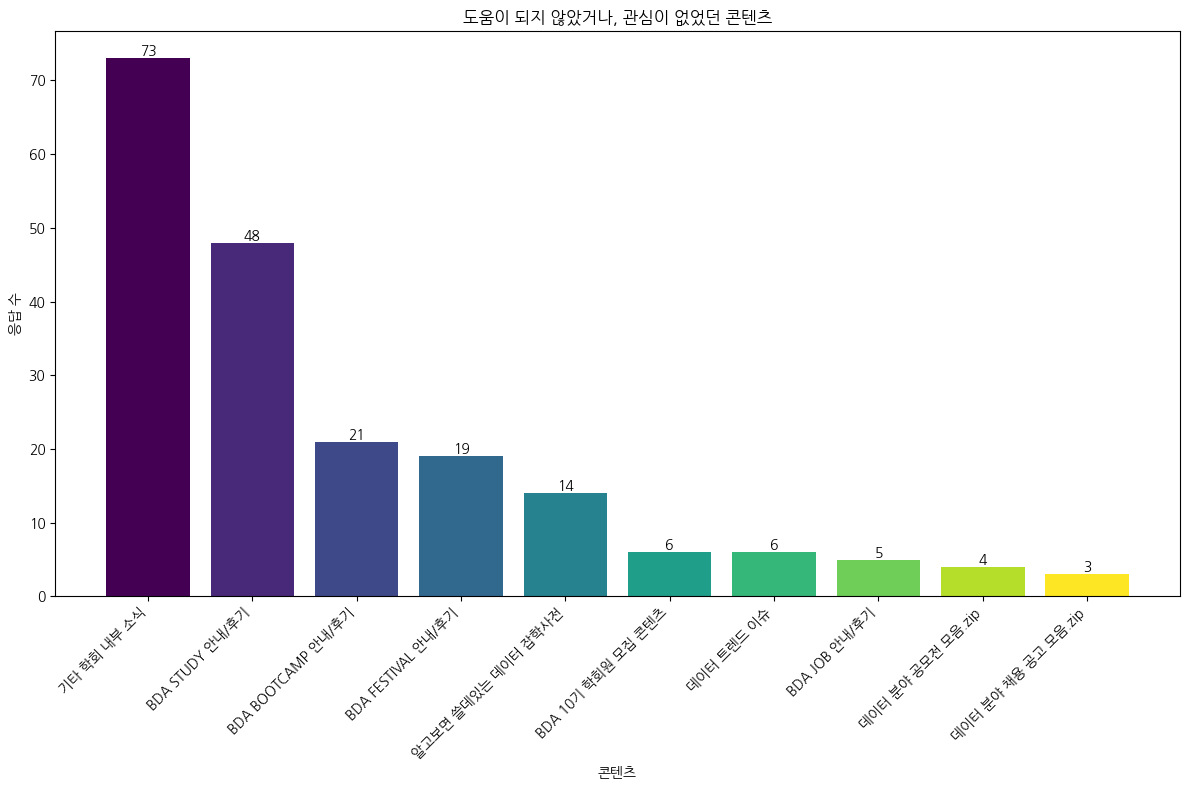

응답 별 수와 비율:
기타 학회 내부 소식: 73명 (36.7%)
BDA STUDY 안내/후기: 48명 (24.1%)
BDA BOOTCAMP 안내/후기: 21명 (10.6%)
BDA FESTIVAL 안내/후기: 19명 (9.5%)
알고보면 쓸데있는 데이터 잡학사전: 14명 (7.0%)
BDA 10기 학회원 모집 콘텐츠: 6명 (3.0%)
데이터 트렌드 이슈: 6명 (3.0%)
BDA JOB 안내/후기: 5명 (2.5%)
데이터 분야 공모전 모음.zip: 4명 (2.0%)
데이터 분야 채용 공고 모음.zip: 3명 (1.5%)

총 응답자 수: 199명


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm

# 컬럼명 설정
column = "official.bdaa 계정에서 도움이 되지 않았거나, 관심이 없었던 콘텐츠는 무엇인가요?"

# 데이터 처리
responses = df_unique[column].dropna()
response_counts = responses.value_counts()

# viridis 컬러맵 설정
cmap = cm.viridis
colors = cmap(np.linspace(0, 1, len(response_counts)))

# 수직 막대 그래프 생성
plt.figure(figsize=(12, 8))
bars = plt.bar(response_counts.index, response_counts.values, color=colors)
plt.xticks(rotation=45, ha='right')  # x축 레이블 회전

# 각 막대 위에 값 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.title("도움이 되지 않았거나, 관심이 없었던 콘텐츠")
plt.xlabel("콘텐츠")
plt.ylabel("응답 수")

# 레이아웃 조정
plt.tight_layout()
plt.show()

# 응답 수와 비율 출력
print("응답 별 수와 비율:")
for response, count in response_counts.items():
    percentage = count / len(responses) * 100
    print(f"{response}: {count}명 ({percentage:.1f}%)")

print(f"\n총 응답자 수: {len(responses)}명")


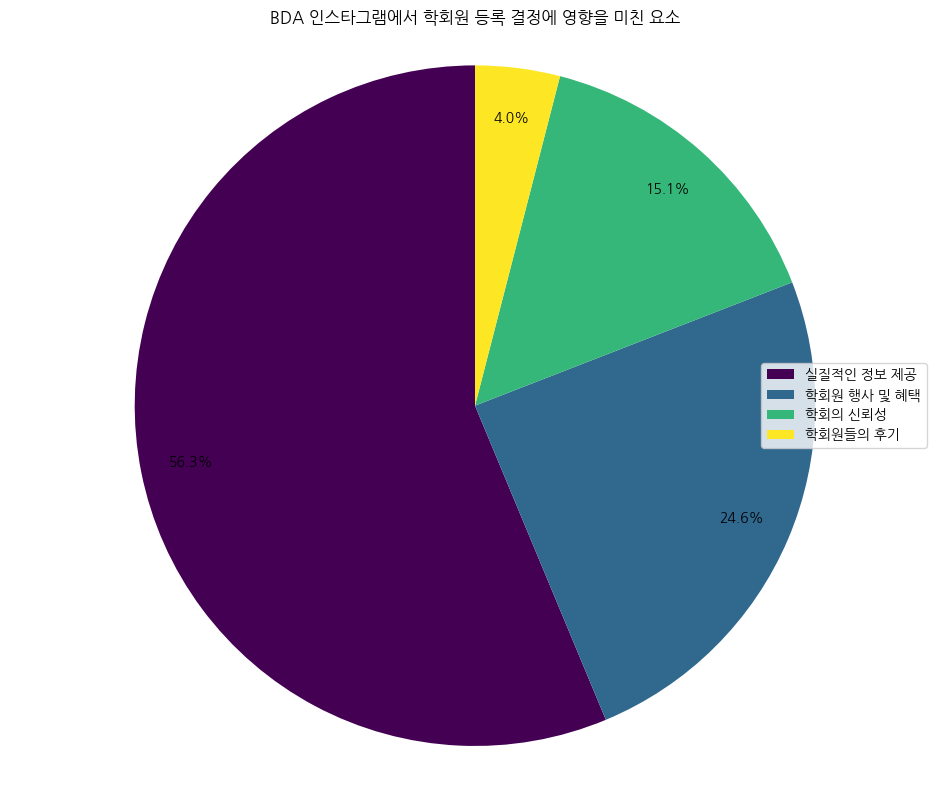

응답 별 수와 비율:
실질적인 정보 제공: 112명 (56.3%)
학회원 행사 및 혜택: 49명 (24.6%)
학회의 신뢰성: 30명 (15.1%)
학회원들의 후기: 8명 (4.0%)

총 응답자 수: 199명


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm

# 컬럼명 설정
column = "BDA 인스타그램에서 어떤 요소가 학회원 등록을 결정하는 데 가장 영향을 미쳤나요?"

# 데이터 처리
responses = df_unique[column].dropna()
response_counts = responses.value_counts()

# viridis 컬러맵 설정
cmap = cm.viridis
colors = cmap(np.linspace(0, 1, len(response_counts)))

# 파이 차트 생성
plt.figure(figsize=(12, 8))
plt.pie(response_counts.values, autopct='%1.1f%%', startangle=90, colors=colors,
        pctdistance=0.85)

plt.title("BDA 인스타그램에서 학회원 등록 결정에 영향을 미친 요소")
plt.axis('equal')  # 원형 유지

# 범례 추가
plt.legend(response_counts.index, loc="center left", bbox_to_anchor=(0.8, 0.5))

# 레이아웃 조정
plt.tight_layout(rect=[0, 0, 0.8, 1])  # 범례 공간 확보
plt.show()

# 응답 수와 비율 출력
print("응답 별 수와 비율:")
for response, count in response_counts.items():
    percentage = count / len(responses) * 100
    print(f"{response}: {count}명 ({percentage:.1f}%)")

print(f"\n총 응답자 수: {len(responses)}명")



<ipython-input-56-0ca3c992c62d>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


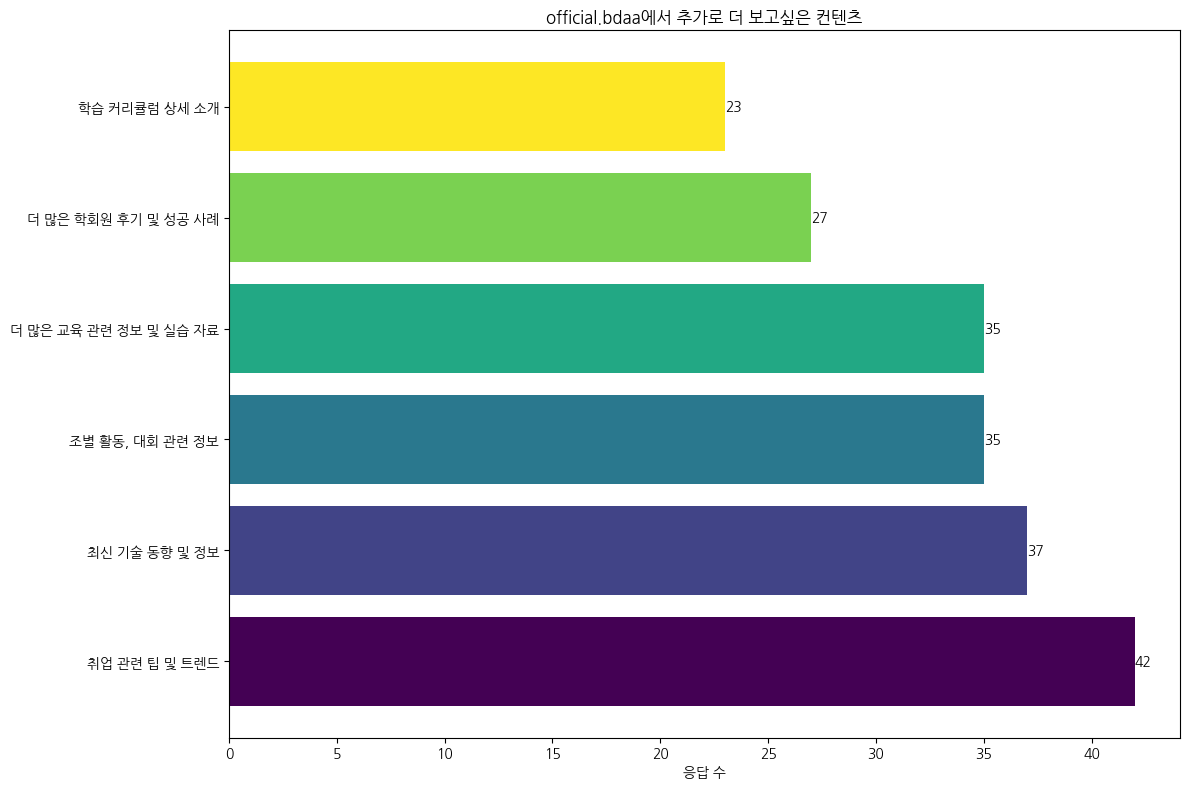

응답 별 수와 비율:
취업 관련 팁 및 트렌드: 42명 (21.1%)
최신 기술 동향 및 정보: 37명 (18.6%)
조별 활동, 대회 관련 정보: 35명 (17.6%)
더 많은 교육 관련 정보 및 실습 자료: 35명 (17.6%)
더 많은 학회원 후기 및 성공 사례: 27명 (13.6%)
학습 커리큘럼 상세 소개: 23명 (11.6%)

총 응답자 수: 199명


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm

# 컬럼명 설정
column = "official.bdaa에서 추가로 더 보고싶은 컨텐츠는 무엇인가요?"

# 데이터 처리
responses = df_unique[column].dropna()
response_counts = responses.value_counts()

# viridis 컬러맵 설정
cmap = cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(response_counts)))

# 수평 막대 그래프 생성
plt.figure(figsize=(12, 8))
y_pos = np.arange(len(response_counts))
bars = plt.barh(y_pos, response_counts.values, color=colors)

# Y축 레이블 설정
plt.yticks(y_pos, response_counts.index)

# 제목 및 레이블 설정
plt.title("official.bdaa에서 추가로 더 보고싶은 컨텐츠")
plt.xlabel("응답 수")

# 각 막대에 값 표시
for i, (v, bar) in enumerate(zip(response_counts.values, bars)):
    plt.text(v, bar.get_y() + bar.get_height()/2, str(v),
             va='center', ha='left', fontweight='bold')

# 레이아웃 조정
plt.tight_layout()
plt.show()

# 응답 수와 비율 출력
print("응답 별 수와 비율:")
for response, count in response_counts.items():
    percentage = count / len(responses) * 100
    print(f"{response}: {count}명 ({percentage:.1f}%)")

print(f"\n총 응답자 수: {len(responses)}명")


<ipython-input-58-aa601845afed>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


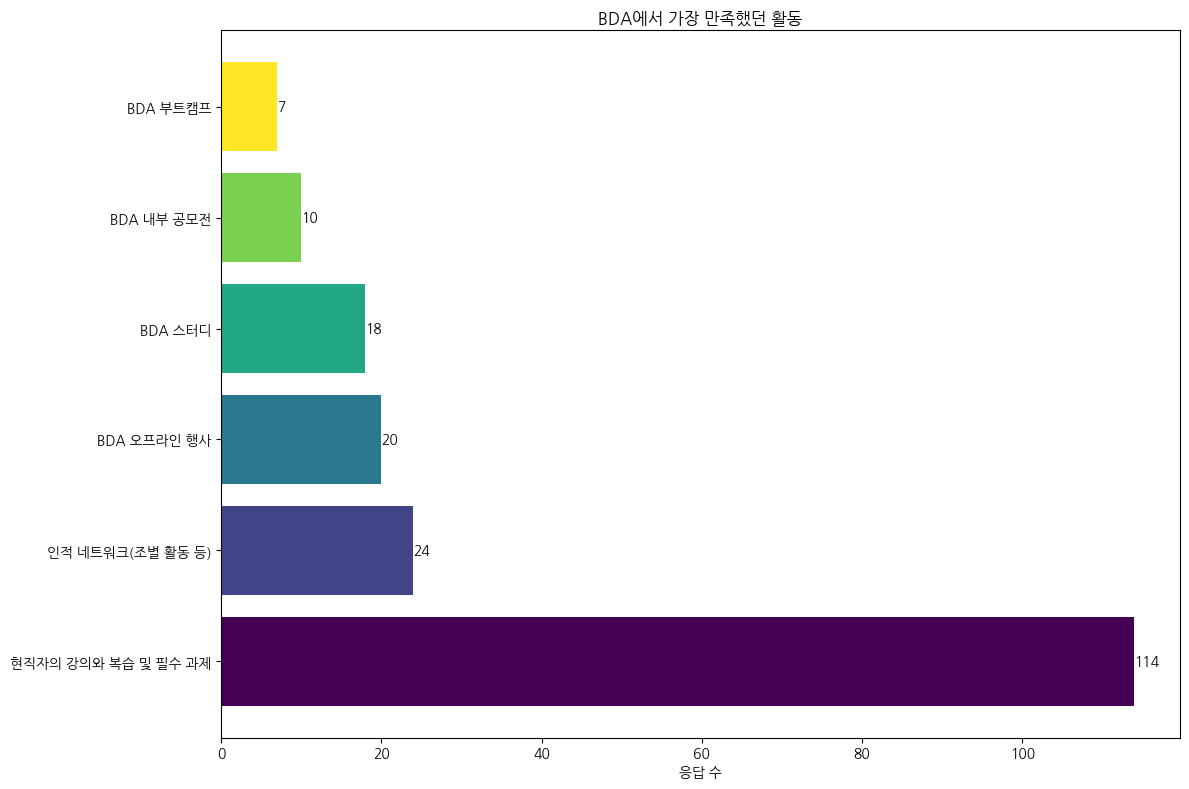

응답 별 수와 비율:
현직자의 강의와 복습 및 필수 과제: 114명 (59.1%)
인적 네트워크(조별 활동 등): 24명 (12.4%)
BDA 오프라인 행사: 20명 (10.4%)
BDA 스터디: 18명 (9.3%)
BDA 내부 공모전: 10명 (5.2%)
BDA 부트캠프: 7명 (3.6%)

총 응답자 수: 193명


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm

# 컬럼명 설정
column = "4-5) BDA에서 가장 만족했던 활동을 선택해주세요."
# 데이터 처리
responses = df_unique[column].dropna()
response_counts = responses.value_counts()

# viridis 컬러맵 설정
cmap = cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(response_counts)))

# 수평 막대 그래프 생성
plt.figure(figsize=(12, 8))
y_pos = np.arange(len(response_counts))
bars = plt.barh(y_pos, response_counts.values, color=colors)

# Y축 레이블 설정
plt.yticks(y_pos, response_counts.index)

# 제목 및 레이블 설정
plt.title("BDA에서 가장 만족했던 활동")
plt.xlabel("응답 수")

# 각 막대에 값 표시
for i, (v, bar) in enumerate(zip(response_counts.values, bars)):
    plt.text(v, bar.get_y() + bar.get_height()/2, str(v),
             va='center', ha='left', fontweight='bold')

# 레이아웃 조정
plt.tight_layout()
plt.show()

# 응답 수와 비율 출력
print("응답 별 수와 비율:")
for response, count in response_counts.items():
    percentage = count / len(responses) * 100
    print(f"{response}: {count}명 ({percentage:.1f}%)")

print(f"\n총 응답자 수: {len(responses)}명")


<ipython-input-60-631a514feef9>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


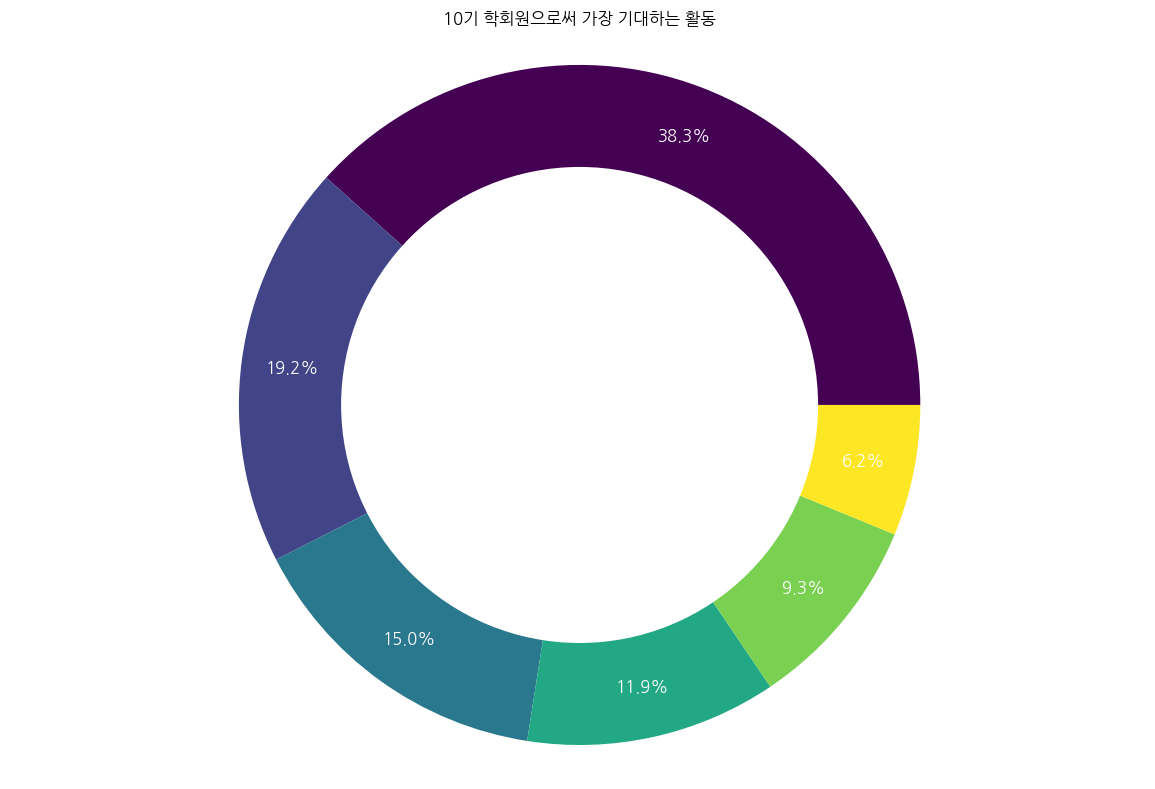

응답 별 수와 비율:
현직자의 강의와 복습 및 필수 과제: 74명 (38.3%)
인적 네트워크(조별 활동 등): 37명 (19.2%)
BDA 내부 공모전: 29명 (15.0%)
BDA 부트캠프: 23명 (11.9%)
BDA 오프라인 행사: 18명 (9.3%)
BDA 스터디: 12명 (6.2%)

총 응답자 수: 193명


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm

# 컬럼명 설정
column = "4-6) 10기 학회원으로써 가장 기대하는 활동을 선택해주세요."

# 데이터 처리
responses = df_unique[column].dropna()
response_counts = responses.value_counts()

# viridis 컬러맵 설정
cmap = cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(response_counts)))

# 도넛 차트 생성
plt.figure(figsize=(12, 8))
plt.pie(response_counts.values, labels=response_counts.index, colors=colors, autopct='%1.1f%%', pctdistance=0.85, wedgeprops=dict(width=0.5),
        textprops={'color':"w", 'fontsize':12, 'fontweight':'bold'})

plt.title("10기 학회원으로써 가장 기대하는 활동")

# 중앙에 원 추가하여 도넛 모양 만들기
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout()
plt.show()

# 응답 수와 비율 출력
print("응답 별 수와 비율:")
for response, count in response_counts.items():
    percentage = count / len(responses) * 100
    print(f"{response}: {count}명 ({percentage:.1f}%)")

print(f"\n총 응답자 수: {len(responses)}명")




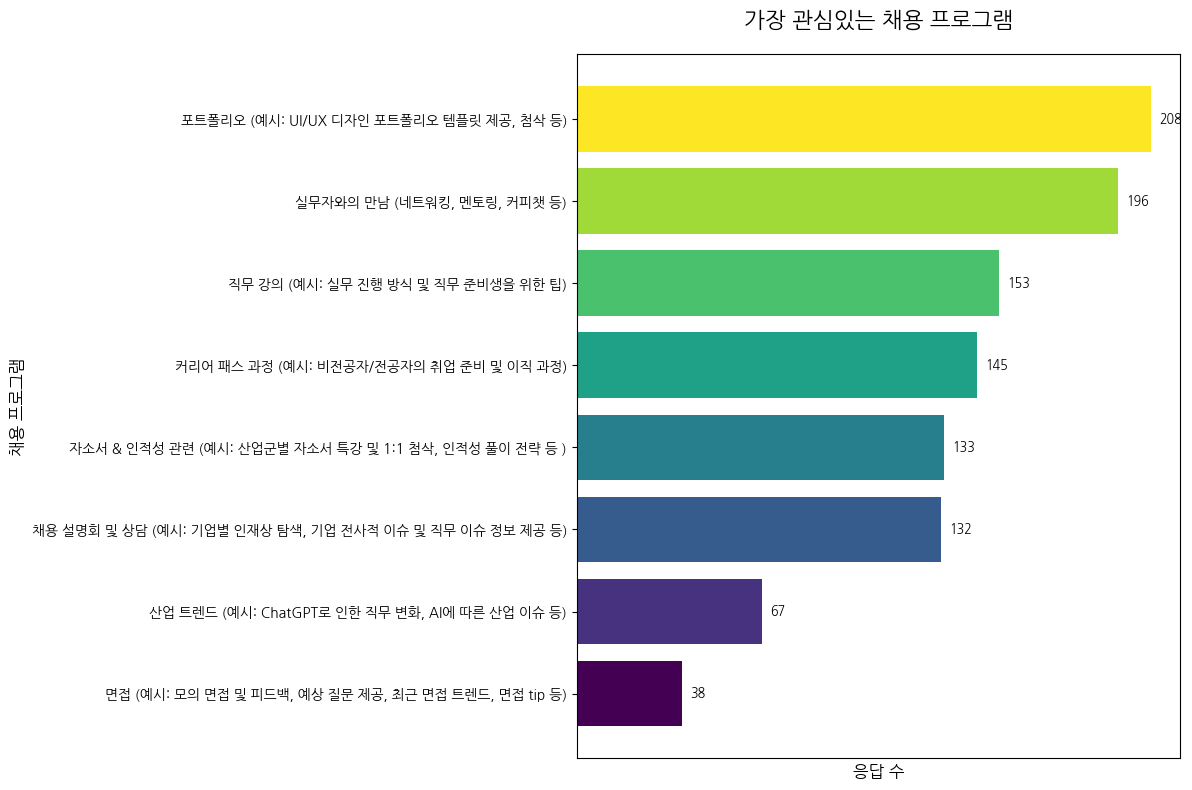

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비
column = "12-1-1)  10기 학회원들을 대상으로 BDA JOB를 통해 학회원분들께 취업 집중 서비스를 제공하고자 합니다. 가장 관심있는 채용 프로그램을 선택해주세요."
data = df[column].value_counts().sort_values(ascending=True)

# 그래프 크기 설정
plt.figure(figsize=(12, 8))

# 수평 막대 그래프 생성 (viridis 컬러맵 적용)
colors = plt.cm.viridis(np.linspace(0, 1, len(data)))
bars = plt.barh(data.index, data.values, color=colors)

# 막대 위에 값 표시
for bar, value in zip(bars, data.values):
    plt.text(bar.get_width() + 3, bar.get_y() + bar.get_height()/2,
             f'{value}', va='center', fontsize=9)

# 그래프 제목 및 레이블 설정
plt.title("가장 관심있는 채용 프로그램", fontsize=16, pad=20)
plt.xlabel("응답 수", fontsize=12)
plt.ylabel("채용 프로그램", fontsize=12)

# X축 눈금 생략
plt.xticks([])  # x축 눈금을 빈 리스트로 설정하여 숨김

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()



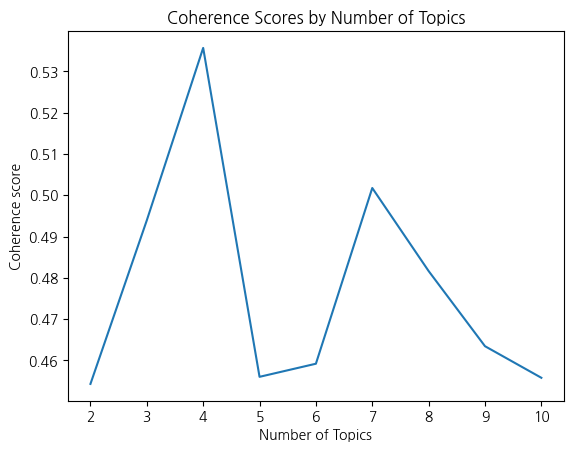

Optimal number of topics: 4
Topic 1: 0.074*"데이터" + 0.054*"대학원" + 0.041*"분석" + 0.034*"금융" + 0.032*"취업" + 0.028*"역량" + 0.028*"면접" + 0.027*"관련" + 0.021*"정보" + 0.021*"진학"
Topic 2: 0.273*"해외" + 0.257*"취업" + 0.218*"지원" + 0.031*"방법" + 0.024*"이직" + 0.022*"효율" + 0.017*"인턴" + 0.015*"관련" + 0.008*"설명" + 0.007*"상담"
Topic 3: 0.097*"포트폴리오" + 0.066*"직무" + 0.046*"강의" + 0.040*"자소" + 0.040*"실무" + 0.030*"경험" + 0.027*"프로젝트" + 0.021*"커피" + 0.021*"도메인" + 0.021*"기회"
Topic 4: 0.235*"특강" + 0.228*"취업" + 0.154*"기업" + 0.117*"중견" + 0.014*"분야" + 0.014*"멘토링" + 0.011*"외국" + 0.011*"대기업" + 0.010*"과정" + 0.009*"스터디"

Coherence Scores:
Number of topics: 2, Coherence Score: 0.4543054695954921
Number of topics: 3, Coherence Score: 0.4939315346158413
Number of topics: 4, Coherence Score: 0.5356771305182002
Number of topics: 5, Coherence Score: 0.4560238151274644
Number of topics: 6, Coherence Score: 0.45919710963794397
Number of topics: 7, Coherence Score: 0.5017523351119675
Number of topics: 8, Coherence Score: 0.48164033009

In [ ]:
# konlpy 설치
!pip install konlpy

# 필요한 라이브러리 임포트
from konlpy.tag import Okt
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

# 데이터 전처리 (이미 중복이 제거된 df_unique를 사용)
okt = Okt()
column = "12-1-2) 이외에 받고 싶은 취업 및 채용 서비스가 있다면 적어주세요.  예시) 중견기업 취업 특강, 해외 취업 지원, 효율적인 이직 방법 등"

def preprocess_text(text):
    if isinstance(text, str):
        tokens = okt.nouns(text)
        return [token for token in tokens if len(token) > 1]
    return []

# 이미 중복이 제거된 df_unique를 사용
corpus = df_unique[column].dropna().apply(preprocess_text).tolist()
dictionary = corpora.Dictionary(corpus)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]

def compute_coherence_values(dictionary, doc_term_matrix, corpus, texts, start=2, limit=15, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# 결과 계산
limit=11; start=2; step=1
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, doc_term_matrix=doc_term_matrix, corpus=corpus, texts=corpus, start=start, limit=limit, step=step)

# 결과 시각화
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Scores by Number of Topics")
plt.show()

# 최적의 토픽 수 선택
optimal_num_topics = x[coherence_values.index(max(coherence_values))]
print(f"Optimal number of topics: {optimal_num_topics}")

# 최적의 모델 선택
optimal_model = model_list[coherence_values.index(max(coherence_values))]

# 최적의 모델로 토픽 출력
for idx, topic in optimal_model.print_topics(-1):
    print(f"Topic {idx + 1}: {topic}")

# Coherence scores 출력
print("\nCoherence Scores:")
for num_topics, score in zip(x, coherence_values):
    print(f"Number of topics: {num_topics}, Coherence Score: {score}")



Topic 1: 0.069*"관련" + 0.068*"직무" + 0.062*"데이터" + 0.049*"강의" + 0.042*"분석" + 0.035*"경험" + 0.035*"포트폴리오" + 0.033*"대학원" + 0.021*"진학" + 0.021*"과정"


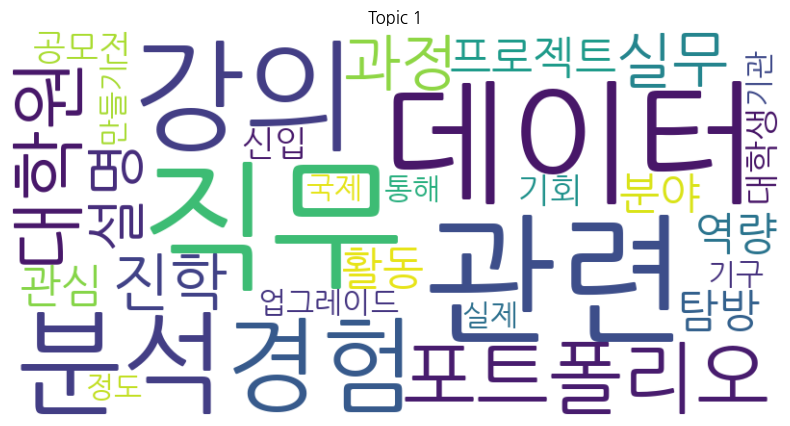

Topic 2: 0.135*"방법" + 0.104*"이직" + 0.094*"효율" + 0.033*"상담" + 0.029*"자소" + 0.024*"직무" + 0.022*"데이터" + 0.021*"대학원" + 0.021*"실무" + 0.012*"기회"


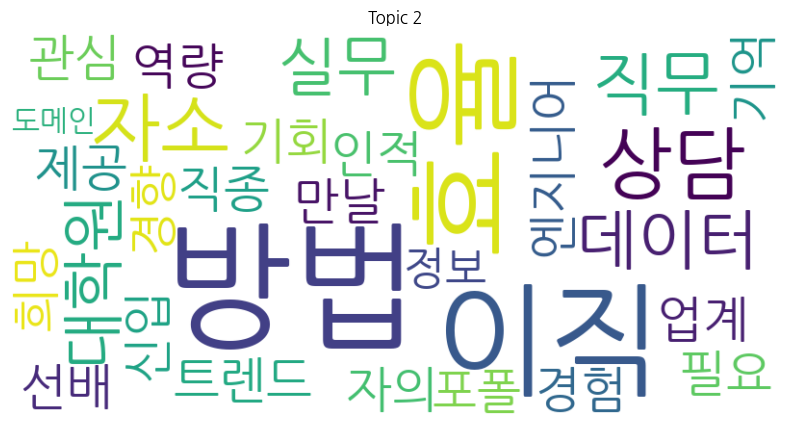

Topic 3: 0.244*"특강" + 0.214*"취업" + 0.159*"기업" + 0.121*"중견" + 0.014*"금융" + 0.009*"현직" + 0.009*"스터디" + 0.007*"도메인" + 0.006*"분야" + 0.006*"결정"


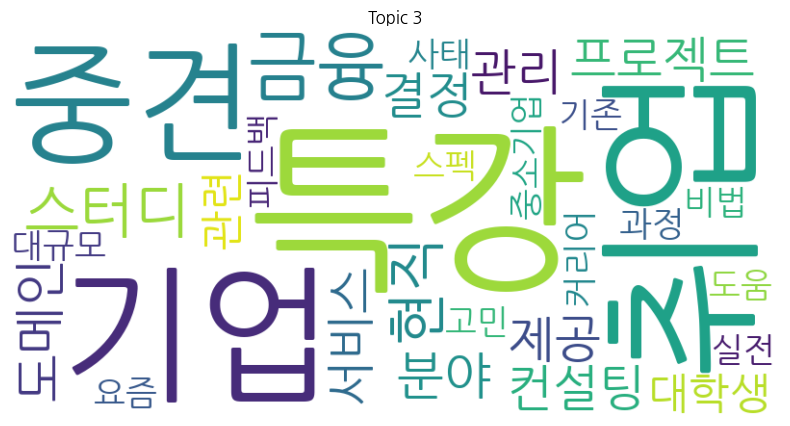

Topic 4: 0.290*"취업" + 0.277*"해외" + 0.217*"지원" + 0.015*"외국" + 0.010*"대기업" + 0.008*"전공자" + 0.006*"대학원" + 0.006*"설명" + 0.005*"만남" + 0.005*"포함"


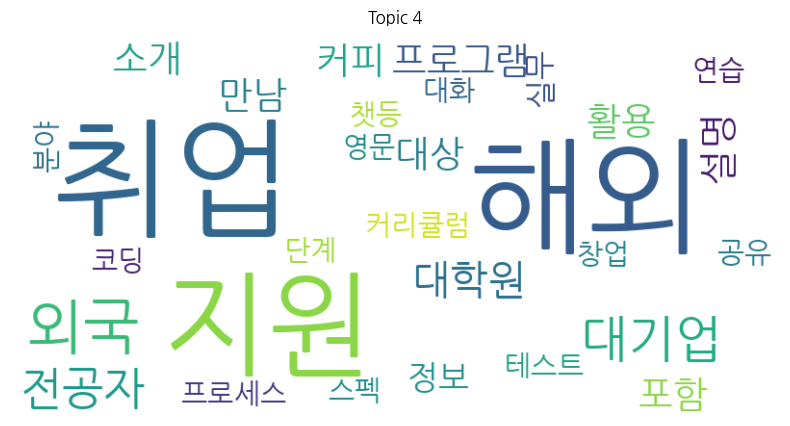

Topic 5: 0.125*"포트폴리오" + 0.088*"인턴" + 0.075*"준비" + 0.063*"멘토링" + 0.043*"자소" + 0.039*"면접" + 0.027*"방향성" + 0.027*"채용" + 0.016*"지원" + 0.015*"관련"


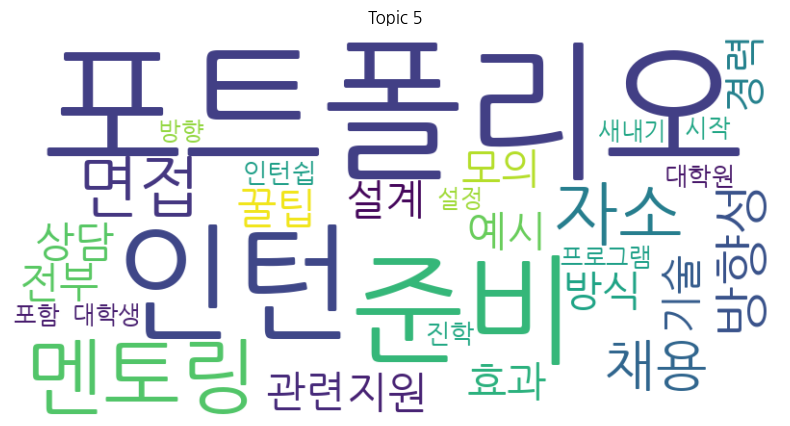

In [ ]:
from konlpy.tag import Okt
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 데이터 전처리
okt = Okt()
column = "12-1-2) 이외에 받고 싶은 취업 및 채용 서비스가 있다면 적어주세요.  예시) 중견기업 취업 특강, 해외 취업 지원, 효율적인 이직 방법 등"

def preprocess_text(text):
    if isinstance(text, str):
        tokens = okt.nouns(text)
        return [token for token in tokens if len(token) > 1]
    return []

# df_unique를 사용하여 corpus 생성
corpus = df_unique[column].dropna().apply(preprocess_text).tolist()
dictionary = corpora.Dictionary(corpus)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in corpus]

# LDA 모델 생성 (토픽 수는 예시로 5로 설정)
lda_model = models.LdaModel(doc_term_matrix, num_topics=5, id2word=dictionary, passes=50)

# 워드클라우드 생성
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx + 1}: {topic}")

    # 토픽의 단어와 가중치를 딕셔너리로 변환
    topic_words = dict([(word, float(weight)) for word, weight in lda_model.show_topic(idx, 30)])

    # 워드클라우드 생성
    wordcloud = WordCloud(
        font_path="/usr/share/fonts/truetype/nanum/NanumGothic.ttf",
        background_color="white",
        width=800,
        height=400
    ).generate_from_frequencies(topic_words)

    # 워드클라우드 표시
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {idx + 1}")
    plt.show()



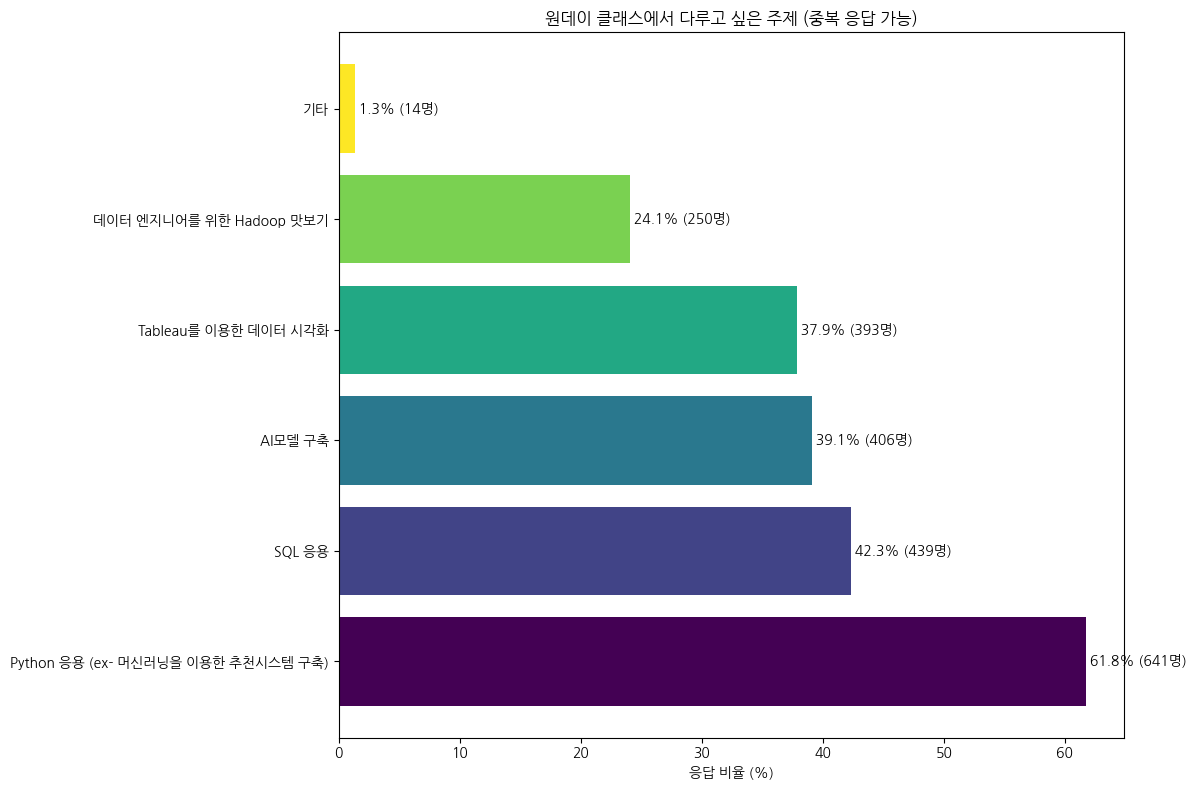

총 응답자 수: 1038명


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 데이터프레임 df_unique가 이미 로드되어 있다고 가정합니다.
column = "12-2-1) 저희 학회는 학회원의 성장을 위해 현직에 종사하시는 분들을 초대하여 데이터 분석과 관련 있는 강연을 하는 원데이 클래스라는 프로그램을 진행합니다. 원데이 클래스에서 다뤘으면 하는 주제를 모두 선택해주세요."

responses = df_unique[column].dropna()
total_respondents = len(responses)

# 응답 분리 및 정리
all_responses = []
for response in responses:
    items = [item.strip() for item in response.split(',')]
    all_responses.extend(items)

# OCR 결과에서 얻은 주요 항목 (정확하게 일치해야 함)
known_topics = [
    "Python 응용 (ex- 머신러닝을 이용한 추천시스템 구축)",
    "SQL 응용",
    "AI모델 구축",
    "Tableau를 이용한 데이터 시각화",
    "데이터 엔지니어를 위한 Hadoop 맛보기"
]

# 알려진 항목 외의 응답은 "기타"로 처리
other_count = 0
cleaned_responses = []
for response in all_responses:
    if response in known_topics:
        cleaned_responses.append(response)
    else:
        other_count += 1  # 기타 항목에 대한 응답 수 증가

# Pandas Series로 변환
response_counts = pd.Series(cleaned_responses).value_counts()

# "기타" 항목 추가
response_counts["기타"] = other_count

# 응답 비율 계산
response_percentages = (response_counts / total_respondents) * 100

# 그래프 생성
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(response_percentages)))
bars = plt.barh(response_percentages.index, response_percentages.values, color=colors)

plt.title("원데이 클래스에서 다루고 싶은 주제 (중복 응답 가능)")
plt.xlabel("응답 비율 (%)")

# 각 막대에 값 표시
for i, (value, count) in enumerate(zip(response_percentages.values, response_counts.values)):
    plt.text(value, i, f' {value:.1f}% ({count}명)', va='center', ha='left', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"총 응답자 수: {total_respondents}명")




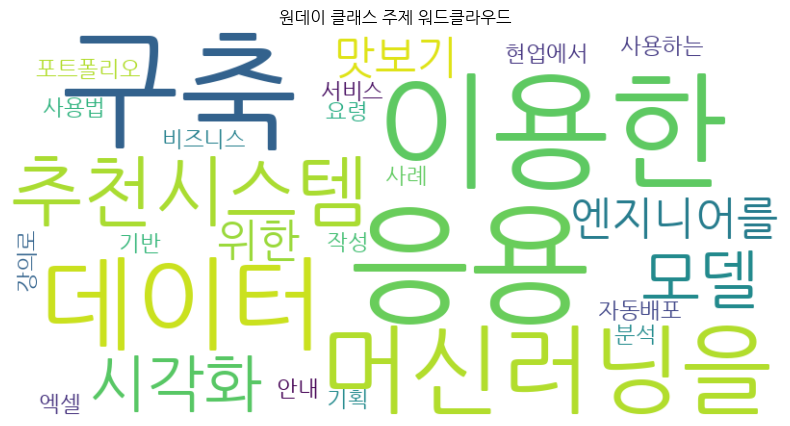

In [ ]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import re

# 데이터프레임 df_unique가 이미 로드되어 있다고 가정합니다.
column = "12-2-1) 저희 학회는 학회원의 성장을 위해 현직에 종사하시는 분들을 초대하여 데이터 분석과 관련 있는 강연을 하는 원데이 클래스라는 프로그램을 진행합니다. 원데이 클래스에서 다뤘으면 하는 주제를 모두 선택해주세요."

responses = df_unique[column].dropna()

# 기타 응답 텍스트 추출
etc_text = ' '.join(responses)

# 불용어 리스트
stopwords = set(['없음', '잘모름'])

# 단어 추출 및 전처리
def preprocess_text(text):
    # 한글과 공백만 남기고 제거
    text = re.sub(r'[^가-힣\s]', '', text)
    # 2글자 이상의 단어만 추출하고 불용어 제거
    words = [word for word in text.split() if len(word) >= 2 and word not in stopwords]
    return words

words = preprocess_text(etc_text)

# 단어 빈도 계산
word_freq = dict(Counter(words))

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # 한글 폰트 경로
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(word_freq)

# 워드클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('원데이 클래스 주제 워드클라우드')
plt.show()



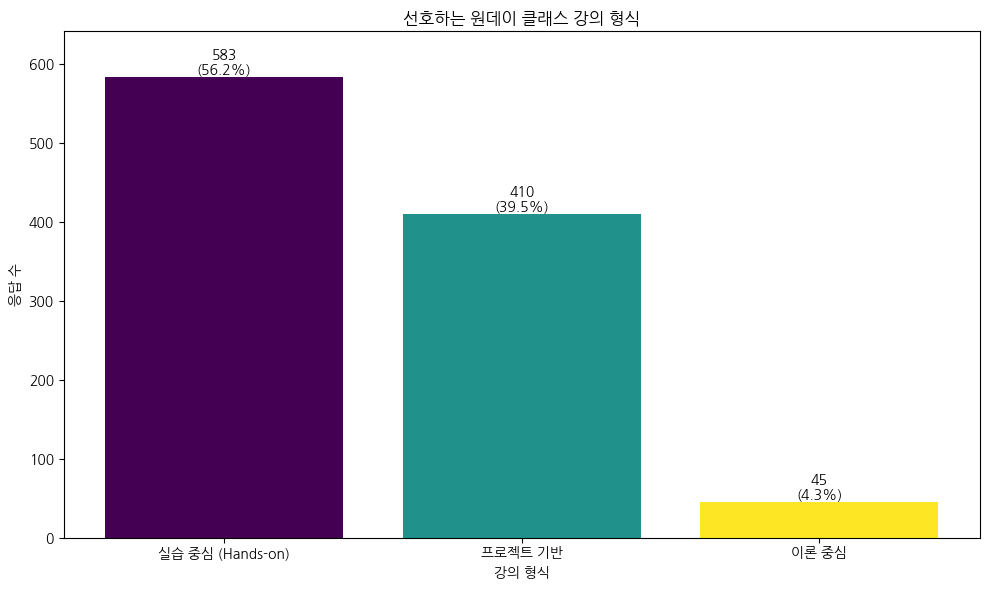

총 응답자 수: 1038명


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 데이터프레임 df_unique가 이미 로드되어 있다고 가정합니다.
column = "12-2-2) 선호하는 원데이 클래스 강의 형식을 선택해주세요."

# 데이터 처리
responses = df_unique[column].dropna()

# 응답 분류 함수
def classify_response(response):
    if '실습' in response or 'Hands-on' in response:
        return '실습 중심 (Hands-on)'
    elif '이론' in response:
        return '이론 중심'
    elif '프로젝트' in response:
        return '프로젝트 기반'
    else:
        return '기타'

# 응답 분류
classified_responses = responses.apply(classify_response)

# 응답 빈도 계산
response_counts = classified_responses.value_counts()
total_responses = len(classified_responses)

# 응답 비율 계산
response_percentages = (response_counts / total_responses) * 100

# 그래프 생성
plt.figure(figsize=(10, 6))
bars = plt.bar(response_counts.index, response_counts.values, color=plt.cm.viridis(np.linspace(0, 1, len(response_counts))))

plt.title("선호하는 원데이 클래스 강의 형식")
plt.xlabel("강의 형식")
plt.ylabel("응답 수")

# y축 범위 설정 (최대값의 10% 여유를 둠)
plt.ylim(0, max(response_counts.values) * 1.1)

# 각 막대 위에 값 표시
for i, (count, percentage) in enumerate(zip(response_counts.values, response_percentages)):
    plt.text(i, count, f'{count}\n({percentage:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"총 응답자 수: {total_responses}명")

# '기타' 응답 내용 출력 (선택적)
other_responses = responses[classified_responses == '기타']
if not other_responses.empty:
    print("\n기타 응답:")
    for response in other_responses:
        print(f"- {response}")



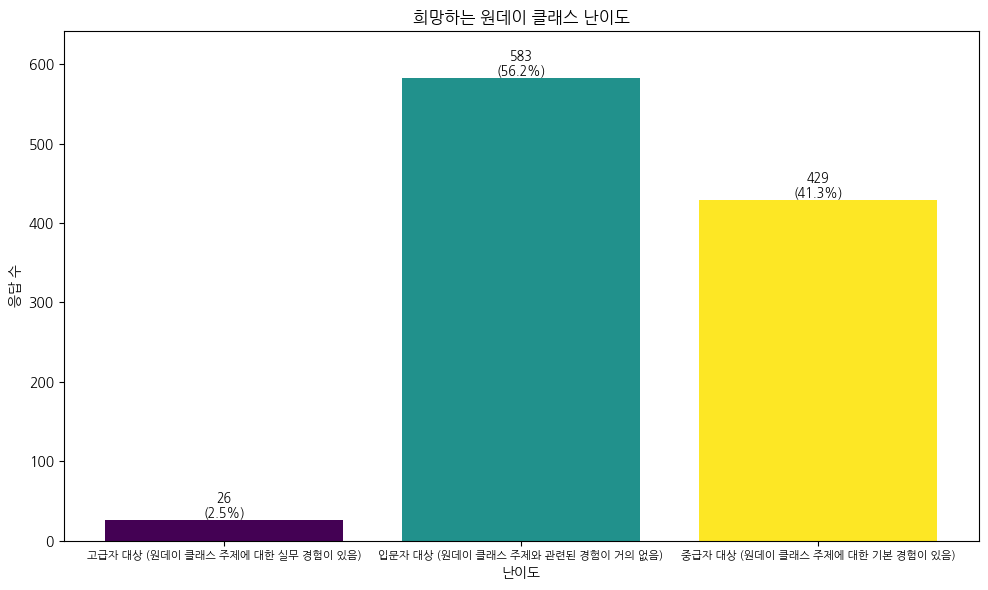

총 응답자 수: 1038명

난이도별 응답:
고급자 대상 (원데이 클래스 주제에 대한 실무 경험이 있음): 26명 (2.5%)
입문자 대상 (원데이 클래스 주제와 관련된 경험이 거의 없음): 583명 (56.2%)
중급자 대상 (원데이 클래스 주제에 대한 기본 경험이 있음): 429명 (41.3%)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 데이터프레임 df_unique가 이미 로드되어 있다고 가정합니다.
column = "12-2-3) 희망하는 원데이 클래스 난이도를 선택해주세요."

# 데이터 처리
responses = df_unique[column].dropna()
response_counts = responses.value_counts().sort_index()
total_responses = len(responses)

# 응답 비율 계산
response_percentages = (response_counts / total_responses) * 100

# 그래프 생성
plt.figure(figsize=(10, 6))
bars = plt.bar(response_counts.index, response_counts.values, color=plt.cm.viridis(np.linspace(0, 1, len(response_counts))))

plt.title("희망하는 원데이 클래스 난이도")
plt.xlabel("난이도")
plt.ylabel("응답 수")

# y축 범위 설정 (최대값의 10% 여유를 둠)
plt.ylim(0, max(response_counts.values) * 1.1)

# 각 막대 위에 값 표시 (크기, 색상 조정)
for i, (count, percentage) in enumerate(zip(response_counts.values, response_percentages)):
    plt.text(i, count, f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=9, color='black')

# x축 레이블 겹침 방지
plt.xticks(fontsize=8)

plt.tight_layout()
plt.show()

print(f"총 응답자 수: {total_responses}명")

# 각 난이도별 응답 수와 비율 출력
print("\n난이도별 응답:")
for level, count in response_counts.items():
    percentage = (count / total_responses) * 100
    print(f"{level}: {count}명 ({percentage:.1f}%)")


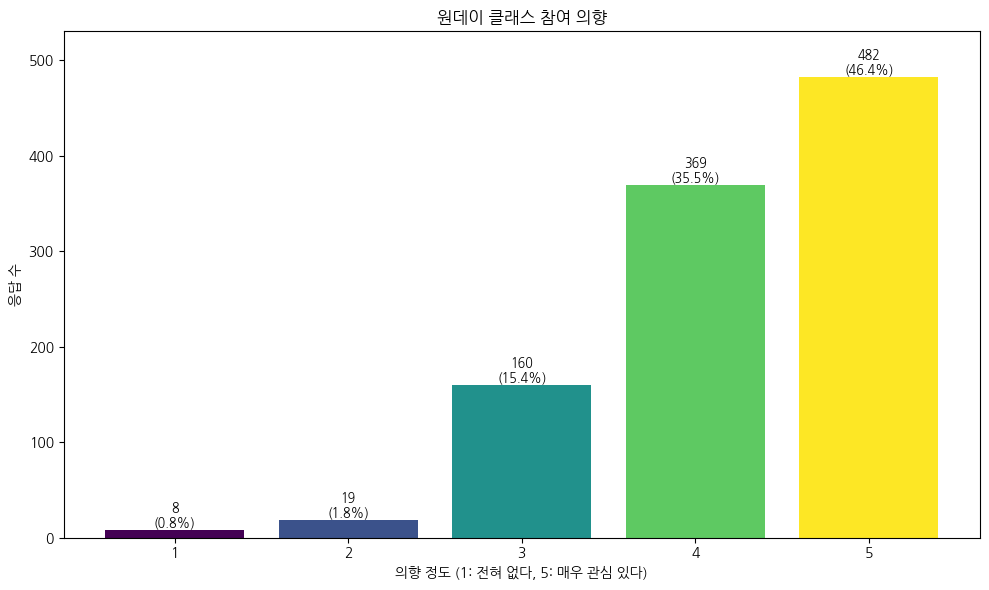

총 응답자 수: 1038명

의향 정도별 응답:
1: 8명 (0.8%)
2: 19명 (1.8%)
3: 160명 (15.4%)
4: 369명 (35.5%)
5: 482명 (46.4%)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 데이터프레임 df_unique가 이미 로드되어 있다고 가정합니다.
column = "12-2-4) 원데이 클래스에 실제 참여할 의향이 얼마나 있으신가요?"

# 데이터 처리
responses = df_unique[column].dropna()

# 숫자 응답 빈도 계산
response_counts = responses.value_counts().sort_index()
total_responses = len(responses)

# 응답 비율 계산
response_percentages = (response_counts / total_responses) * 100

# 그래프 생성
plt.figure(figsize=(10, 6))

# viridis 컬러맵을 사용하여 막대 색상 설정
num_bars = len(response_counts)
colors = plt.cm.viridis(np.linspace(0, 1, num_bars))
bars = plt.bar(response_counts.index, response_counts.values, color=colors)

plt.title("원데이 클래스 참여 의향")
plt.xlabel("의향 정도 (1: 전혀 없다, 5: 매우 관심 있다)")
plt.ylabel("응답 수")

# y축 범위 설정 (최대값의 10% 여유를 둠)
plt.ylim(0, max(response_counts.values) * 1.1)

# 각 막대 위에 값 표시
for i, (count, percentage) in enumerate(zip(response_counts.values, response_percentages)):
    plt.text(i + 1, count, f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=9, color='black')

plt.xticks(np.arange(1, 6))  # x축 눈금 설정

plt.tight_layout()
plt.show()

print(f"총 응답자 수: {total_responses}명")

# 각 의향 정도별 응답 수와 비율 출력
print("\n의향 정도별 응답:")
for level, count in response_counts.items():
    percentage = (count / total_responses) * 100
    print(f"{level}: {count}명 ({percentage:.1f}%)")


In [ ]:
# 데이터 준비
column = "12-2-5) 원데이 클래스에 기대하는 점이나 추가로 원하는 사항이 있으면 자유롭게 작성해주세요."
responses = df[column].dropna()
print(f"원데이 클래스에 대한 기대사항을 작성한 응답자 수: {len(responses)}")


원데이 클래스에 대한 기대사항을 작성한 응답자 수: 137


In [ ]:
!pip install --upgrade pip
!pip install konlpy


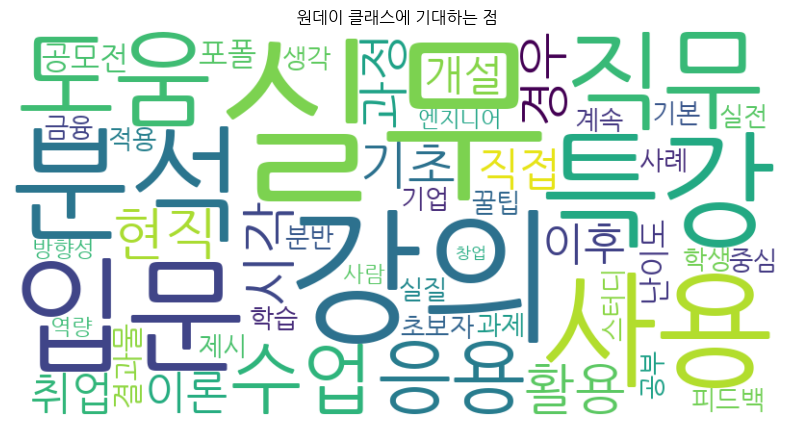

가장 많이 사용된 단어 10개:
실무: 11
강의: 7
사용: 5
입문: 5
특강: 5
분석: 5
직무: 5
도움: 5
응용: 4
수업: 4


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re
import pandas as pd
from konlpy.tag import Okt

# 데이터프레임 df_unique가 이미 로드되어 있다고 가정합니다.
column = "12-2-5) 원데이 클래스에 기대하는 점이나 추가로 원하는 사항이 있으면 자유롭게 작성해주세요."

# 데이터 처리
responses = df_unique[column].dropna()

# 텍스트 전처리 함수
def preprocess_text(text):
    # 한글과 영문자만 남기고 나머지는 공백으로 변경
    text = re.sub(r'[^가-힣a-zA-Z\s]', ' ', text)
    # 불필요한 공백 제거
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()  # 모든 텍스트를 소문자로 변환

# 불용어 목록 (이전 목록에 새로운 불용어 추가)
stopwords = set([
    "합니다", "있습니다", "싶습니다", "바랍니다", "좋겠습니다", "좋겠어요", "같습니다", "같은", "되는", "될", "할", "해", "하는", "했던", "해주시면", "보이도록", "알려주셨으면", "싶은", "수", "좀", "잘", "더", "및", "요", "듯합니다", "많은", "다양한", "실질적인", "실제로", "어떤", "어떻게", "이런", "저", "제가", "그", "도", "요청합니다", "자세히", "고급", "알", "바탕으로", "관련된", "대해", "통해", "없습니다", "있었으면", "해주셨으면",
    "통계", "실제", "추가", "희망", "수준", "관련", "참여","기반","바탕", "개인","데이터", "클래스", "원데이", "프로젝트", "실습", "경험", "내용", "시간", "기회", "부분", "능력", "진행", "제공", "위주", "가능", "입문자", "오프라인", "습득", "이해", "부족", "때문", "정도"
])

# 형태소 분석기 초기화
okt = Okt()

# 명사 추출 및 불용어 제거 함수
def extract_nouns(text):
    nouns = okt.nouns(text)
    return [word for word in nouns if word not in stopwords and len(word) > 1]

# 모든 응답에서 명사 추출
all_nouns = []
for response in responses:
    all_nouns.extend(extract_nouns(preprocess_text(response)))

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # 한글 폰트 경로
    width=800,
    height=400,
    background_color='white',
    max_words=50  # 표시할 단어 수 제한
).generate_from_frequencies(Counter(all_nouns))

# 워드클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(' 원데이 클래스에 기대하는 점')
plt.show()

# 가장 많이 사용된 단어 10개 출력
word_counts = Counter(all_nouns)
print("가장 많이 사용된 단어 10개:")
for word, count in word_counts.most_common(10):
    print(f"{word}: {count}")



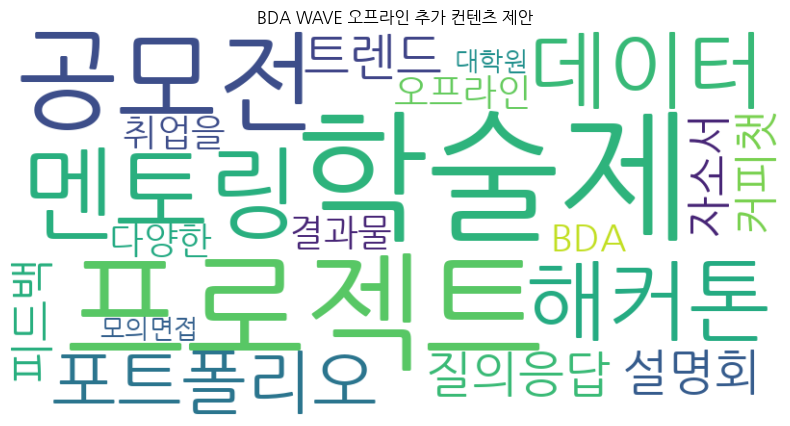

Figure displayed and saved


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import numpy as np

col_wave_additional = "12-3-1) BDA는 BDA WAVE라는 프로그램을 통해 다음의 행사를 진행하고 있습니다.  -  현직자와의 만남(네트워킹 & 커피챗) -  현직자 강연  -  채용 공모전 시상 시 발표 기회 부여 및 현직자의 결과물 멘토링 -  학술제  오프라인 행사에서 추가로 진행되었으면 하는 컨텐츠가 있다면 응답해주세요."

remove_words = ["없음", "모름", "같은", "생각해보겠습니다", "및", "좋겠습니다", "있는", "좋습니다", "아직",
                "충분", "같습니다", "네", "잘 모르겠습니다", "없습니다", "만족합니다", "잘 모르겠음", "모르겠다",
                "없어요", "현직자", "모르겠어요", "없다", "모르겠음", "모르겠습니다", "x", "X", "충분합니다", "기대됩니다", "충분하다고 생각합니다"]

valid_responses = df_unique[col_wave_additional].dropna()
valid_responses = valid_responses[~valid_responses.str.contains('|'.join(remove_words), na=False)]

word_counts = Counter(" ".join(valid_responses).split())
filtered_words = {word: freq for word, freq in word_counts.items() if len(word) > 2 and freq > 2}

wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
                      width=800, height=400, background_color="white",
                      colormap='viridis').generate_from_frequencies(filtered_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("BDA WAVE 오프라인 추가 컨텐츠 제안")
plt.show()
plt.savefig('12-3-1_wordcloud.png')
plt.close()

print("Figure displayed and saved")



Total responses: 1038
Valid responses: 1038
Response values: 12-3-2) BDA WAVE 세부 프로그램인 오프라인 학술제에 참여하실 의사가 있는지 응답해주세요.  (학술제는 정규 학회원 대상 최종 과제 중 우수 과제 발표와 우수학회원 발표가 진행됩니다.)
예      841
아니오    197
Name: count, dtype: int64


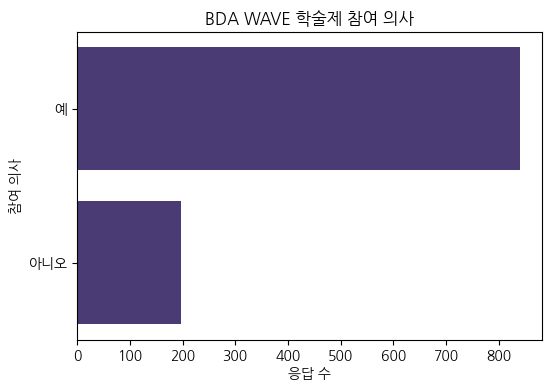

Figure displayed and saved


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

col_wave_participation = "12-3-2) BDA WAVE 세부 프로그램인 오프라인 학술제에 참여하실 의사가 있는지 응답해주세요.  (학술제는 정규 학회원 대상 최종 과제 중 우수 과제 발표와 우수학회원 발표가 진행됩니다.)"

# 데이터 확인
print(f"Total responses: {len(df_unique)}")
print(f"Valid responses: {len(df_unique[col_wave_participation].dropna())}")

# 응답 값 확인
print("Response values:", df_unique[col_wave_participation].value_counts())

plt.figure(figsize=(6, 4))
sns.set_palette("viridis")
sns.countplot(y=df_unique[col_wave_participation].dropna(), order=df_unique[col_wave_participation].value_counts().index)
plt.xlabel("응답 수")
plt.ylabel("참여 의사")
plt.title("BDA WAVE 학술제 참여 의사")
plt.show()  # 그래프를 화면에 표시
plt.savefig('12-3-2_participation.png')
plt.close()

print("Figure displayed and saved")



Total responses: 1038
Valid responses: 378
Number of filtered words: 10
Top 10 words: {'프로젝트': 35, '피드백': 13, '공모전': 11, '다양한': 7, '트렌드': 7, '멘토링': 6, '포트폴리오': 6, '프로그램': 3, '설명회': 3, '스터디': 3}


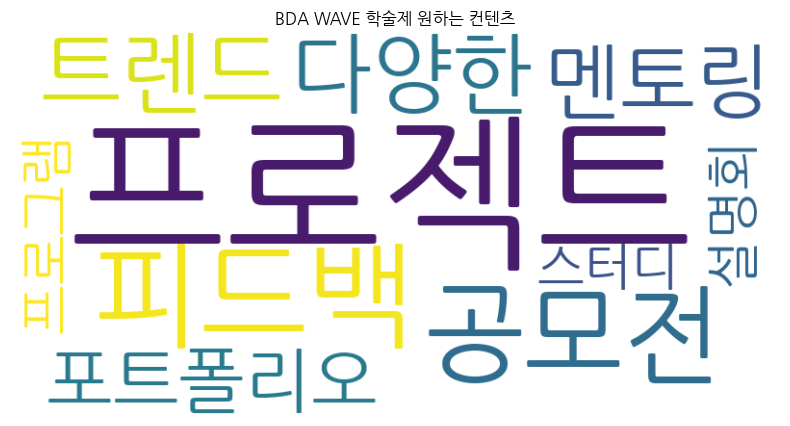

Figure displayed and saved


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import numpy as np
%matplotlib inline

col_wave_contents = "12-3-3) 학술제에서 진행되었으면 하는 컨텐츠를 서술해주세요."

remove_words = ["없음", "모름", "같은", "생각해보겠습니다", "및", "좋겠습니다", "있는", "좋습니다", "아직",
                "충분", "같습니다", "네", "잘 모르겠습니다", "없습니다", "만족합니다", "잘 모르겠음", "모르겠다",
                "없어요", "데이터", "활용한", "현직자", "학회원", "모르겠어요", "없다", "모르겠음", "모르겠습니다", "x", "X", "충분합니다", "기대됩니다", "충분하다고 생각합니다"]

valid_responses = df_unique[col_wave_contents].dropna()
valid_responses = valid_responses[~valid_responses.str.contains('|'.join(remove_words), na=False)]

# 데이터 확인
print(f"Total responses: {len(df_unique)}")
print(f"Valid responses: {len(valid_responses)}")

word_counts = Counter(" ".join(valid_responses).split())
filtered_words = {word: freq for word, freq in word_counts.items() if len(word) > 2 and freq > 2}

# 필터링된 단어 확인
print(f"Number of filtered words: {len(filtered_words)}")
print("Top 10 words:", dict(sorted(filtered_words.items(), key=lambda x: x[1], reverse=True)[:10]))

wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
                      width=800, height=400, background_color="white",
                      colormap='viridis').generate_from_frequencies(filtered_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("BDA WAVE 학술제 원하는 컨텐츠")
plt.show()  # 그래프를 화면에 표시
plt.savefig('12-3-3_wordcloud.png')
plt.close()

print("Figure displayed and saved")
